In [1]:
import scipy

In [2]:
from networkx.algorithms import bipartite
import networkx as nx
#random_graph(n, m, p[, seed, directed])
n = 20
m = 20
p = 0.6
seed = 1
directed = False
G = bipartite.random_graph(n, m, p, seed, directed)
reference_matching = nx.max_weight_matching(G, maxcardinality=True)
assert (len(reference_matching)==n)
import scipy.sparse as sps
# Convert the graph to a SciPy sparse matrix
mat = nx.to_scipy_sparse_array(G,format="lil")
#mat.setdiag(1)
print(mat.shape)

(40, 40)


In [3]:
from scipy.sparse import triu, tril
# Set diagonal to 1 so matrix is invertible
# Extract upper triangle of symmetric sparse matrix
upper_triangle = triu(mat,format="csc", k=1)
lower_triangle = tril(mat,format="csc")
mat=lower_triangle+(upper_triangle*-1)
print(mat.shape)

(40, 40)


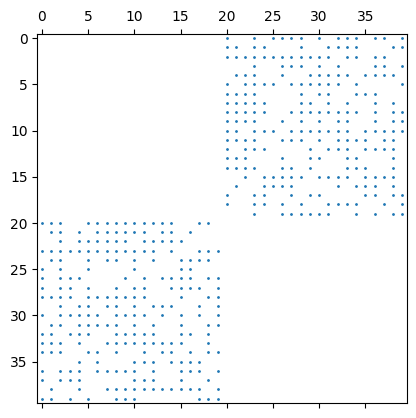

In [4]:
import numpy as np
import scipy as sp
import scipy.sparse
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
%matplotlib inline
plt.spy(mat, aspect='equal', marker='.', markersize=2)


In [5]:
from scipy import linalg
Aij = mat.copy().tocoo()
denseAdj = mat.copy().todense()
invMat = sps.linalg.inv(mat)
denseInv = invMat.copy().todense()
w = linalg.det(denseInv)
rows_removed = set()
cols_removed = set()
matchingGaussian = []
for i,j,v in zip(Aij.row, Aij.col, Aij.data):
    if i != j and i not in rows_removed and j not in cols_removed \
        and j not in rows_removed and i not in cols_removed:
            #print(i,j,v)
            denseS = denseAdj.copy()
            randomNumber = np.random.randint(1, 2*mat.shape[0], size=1)
            denseS[i,j]=randomNumber
            try:
                Bij = linalg.inv(denseS)
                det = linalg.det(Bij)
                if (Bij[j,i]!=0.0):
                    if (det==0.0):
                        print("Bad substitution!!!")
                    else:
                        rows_removed.add(i)
                        cols_removed.add(j)
                        rows_removed.add(j)
                        cols_removed.add(i)
                        denseAdj[i,j]=0.0
                        matchingGaussian.append((i,j))
            except Exception:
                continue
print(matchingGaussian)
assert(len(reference_matching)==len(matchingGaussian))

[(20, 0), (21, 1), (22, 2), (23, 3), (26, 4), (24, 5), (28, 6), (29, 7), (27, 8), (30, 9), (25, 10), (32, 11), (31, 12), (33, 13), (34, 14), (35, 15), (36, 16), (38, 17), (37, 18), (39, 19)]


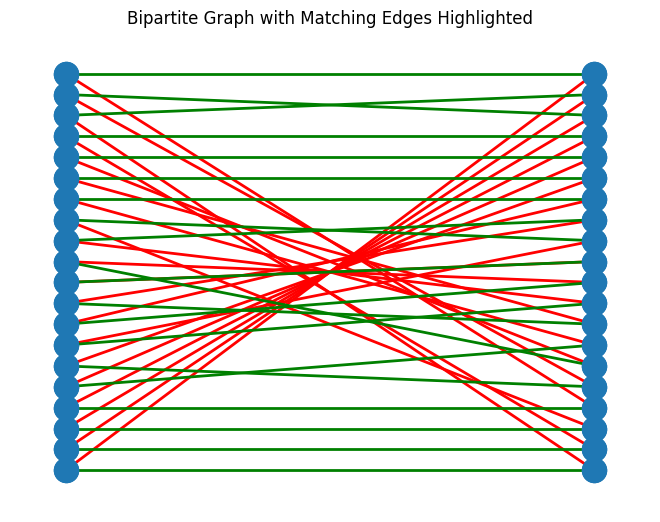

In [8]:
# Draw the graph with the perfect matching edges highlighted
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

# Get the nodes in each partition
partition1_nodes, partition2_nodes = bipartite.sets(G)
# Use bipartite_layout for bipartite graph visualization
pos = nx.bipartite_layout(G, partition1_nodes)

matching_graph = nx.Graph()
matching_graph.add_edges_from(reference_matching)

# Create a new graph with only the matching edges
#matching_gaussian_edges = [(u, v) for u, v in G.edges() if (u, v) in matching or (v, u) in matching]
matching_gaussian_edges = nx.Graph()
matching_gaussian_edges.add_edges_from(matchingGaussian)

# Draw the bipartite graph with matching edges highlighted in red
#nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color=edge_colors, width=2.0)
nx.draw(matching_graph, pos, with_labels=False, edge_color='r', width=2.0)
nx.draw(matching_gaussian_edges, pos, with_labels=False, edge_color='g', width=2.0)

plt.title("Bipartite Graph with Matching Edges Highlighted")
plt.show()
